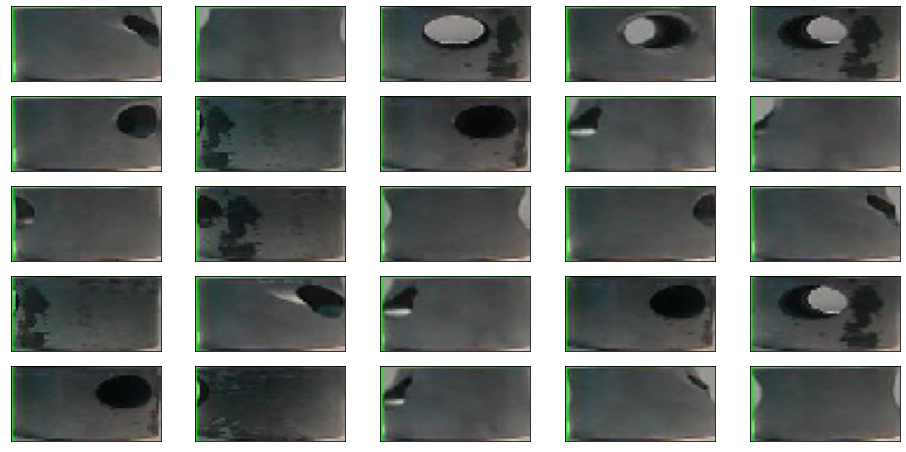

In [1]:
# This function plots images from a folder. 

import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import keras
import tensorflow as tf
import keras_tuner as kt


def plot_images(source_path):
    files=[]
    classes = glob.glob(source_path + '/*')
    for class_path in classes:
        files.extend([f for f in glob.glob(class_path + "/*", recursive=True)])
    random.shuffle(files)
    plt.figure(figsize=(16, 8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        img = image.load_img(files[i], target_size=(32, 64))
        plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
    
plot_images('data/train_data')

In [2]:
IMG_HEIGHT = 80
IMG_WIDTH = 80

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(directory='data/train_data',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_generator.flow_from_directory(directory='data/test_data',
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical')


Found 228 images belonging to 3 classes.
Found 57 images belonging to 3 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


def model_builder(hp):

    num_nodes = hp.Int('units', min_value=8, max_value=64)
    padding = hp.Choice('padding', values=['same', 'valid'])
    lr = hp.Choice('learning_rate', values=[0.001, 0.0001, 0.005, 0.0005])

    #can't use touples
    #kernel = hp.Choice('kernel_size', values=[(3,3), (5,5), (7,7)])


    model = Sequential([
        tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        tf.keras.layers.MaxPool2D(strides=(1,1), padding=padding),
        Dense(num_nodes, activation='relu'),
        Flatten(),
        Dense(3)
    ])   

    model.compile(optimizer=Adam(learning_rate=lr),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
objective='val_loss',
max_epochs=30,
factor=3,
project_name='model_3')

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


tuner.search(train_data_gen, epochs=50, callbacks=[stop], validation_data=val_data_gen)

#model = Sequential([
 #   tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
  #  tf.keras.layers.MaxPool2D(strides=(1,1), padding='same'),
   # Dense(24, activation='relu'),
    #Flatten(),
    #Dense(3)
#])

Trial 90 Complete [00h 00m 05s]
val_loss: 0.1701965630054474

Best val_loss So Far: 0.04665246605873108
Total elapsed time: 00h 03m 33s
INFO:tensorflow:Oracle triggered exit


In [4]:
#tuner.results_summary()
models = tuner.get_best_models(num_models=20)
model10 = models[0]

model10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 3)         84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 3)        0         
 )                                                               
                                                                 
 dense (Dense)               (None, 78, 78, 13)        52        
                                                                 
 flatten (Flatten)           (None, 79092)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 237279    
                                                                 
Total params: 237,415
Trainable params: 237,415
Non-trainable params: 0
__________________________________________________

In [9]:
best_hps=tuner.get_best_hyperparameters(num_trials=5)[0]

#model = tuner.hypermodel.build(best_hps)

#history = model.fit(train_data_gen, epochs=50, callbacks=[stop], validation_data=val_data_gen)

best_hps.values
#history = model.fit(train_data_gen, epochs=50, callbacks=[stop], validation_data=val_data_gen)

{'units': 13,
 'padding': 'same',
 'learning_rate': 0.005,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0065'}

In [10]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory='data/test_data',
                                                         shuffle=False,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical')

loss, accuracy = model10.evaluate(test_data_gen)
print("loss: %f, accuracy: %f" % (loss, accuracy))

Found 57 images belonging to 3 classes.
2/2 [==============================] - 0s 9ms/step - loss: 0.0467 - accuracy: 1.0000
loss: 0.046652, accuracy: 1.000000


In [11]:
import pickle
model_dir = './tensorflow'
model10.save(model_dir)

file_pickle = open('top_20.pkl', 'wb')
pickle.dump(models, file_pickle)
file_pickle.close()

INFO:tensorflow:Assets written to: ram://0d539d61-5852-40a3-bacb-d4d303930d17/assets
INFO:tensorflow:Assets written to: ram://1abaa1b1-314e-456c-a969-826af58a0b40/assets
INFO:tensorflow:Assets written to: ram://9fbacd8f-240f-4ff6-a8a3-4870b13a4e5e/assets
INFO:tensorflow:Assets written to: ram://614a0b58-0be0-4513-8123-7f90fbe38073/assets
INFO:tensorflow:Assets written to: ram://98ed8303-4acc-4f99-bc70-9e4eb0cbcf6b/assets
INFO:tensorflow:Assets written to: ram://b6a82ebe-0afa-40f6-9c74-79bb17d7eb57/assets
INFO:tensorflow:Assets written to: ram://9182ea76-ccc3-4a2c-bf0e-bf648c9b17b1/assets
INFO:tensorflow:Assets written to: ram://455532bd-2836-4dd8-88ba-557b89ff290e/assets
INFO:tensorflow:Assets written to: ram://c80f97a1-1224-4a96-bd92-04db91af67ad/assets
INFO:tensorflow:Assets written to: ram://3af037fd-ad67-45d5-b96f-d6d53f7206a7/assets
INFO:tensorflow:Assets written to: ram://9403201d-d365-42dc-8864-e4fd67f92253/assets
INFO:tensorflow:Assets written to: ram://eada2c87-f2b3-4dae-9db1-

In [12]:
#import tensorflow as tf
#import numpy as np

#new_model_file = open('model.pkl', 'rb')
#model = pickle.load(new_model_file)
#model = tf.keras.Sequential([tf.keras.layers.Rescaling(scale=1./255), model, tf.keras.layers.ReLU()])

#label = {0: 'Defect 1', 1: 'Defect 2', 2: 'Normal'}

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://b85b1aa6-2eb8-49f1-8b7e-c3c3ee93b635/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
#path = './data/test_data/defect_2/defect2_76.jpeg'
#img = tf.keras.preprocessing.image.load_img(path, target_size=(80,80))
#inputarr = tf.keras.preprocessing.image.img_to_array(img)
#img_array = np.array([inputarr])


#predictions = model.predict(img_array)
#score = tf.nn.softmax(predictions[0])

#print(
 #   "This image most likely belongs to {} with a {:.2f} percent confidence."
  #  .format(label[np.argmax(score)], 100 * np.max(score))
#)

#print(score)

This image most likely belongs to Defect 2 with a 98.48 percent confidence.
tf.Tensor([0.00758621 0.98482764 0.00758621], shape=(3,), dtype=float32)


In [ ]:
# import keras

# img = keras.preprocessing.image.load_img('./data/test_data/defect_1/defect_87.jpeg', target_size=(80,80))
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(label[np.argmax(score)], 100 * np.max(score))
# )

# print(score)

This image most likely belongs to Defect 1 with a 88.22 percent confidence.
tf.Tensor([0.88215196 0.01742122 0.10042677], shape=(3,), dtype=float32)


In [ ]:
# img = keras.preprocessing.image.load_img('./data/test_data/normal/normal_97.jpeg', target_size=(80,80))
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(label[np.argmax(score)], 100 * np.max(score))
# )

# print(score)

This image most likely belongs to Normal with a 84.73 percent confidence.
tf.Tensor([0.07632941 0.07632941 0.8473412 ], shape=(3,), dtype=float32)
